In [3]:
!pip install pyEDFlib

  Using cached pyedflib-0.1.42.tar.gz (2.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pyEDFlib


  error: subprocess-exited-with-error
  
  × Building wheel for pyEDFlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [46 lines of output]
      C:\Users\aparn\AppData\Local\Temp\pip-build-env-8edze420\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: BSD License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finalize_license_expression()
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-313

Found EDF files: ['r01.edf', 'r04.edf', 'r07.edf', 'r08.edf', 'r10.edf']

Loading r01.edf ...
Extracting EDF parameters from C:\Users\aparn\OneDrive\PROJECT_S3\IBS\abdominal-and-direct-fetal-ecg-database-1.0.0\r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Channels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling rate: 1000.0 Hz


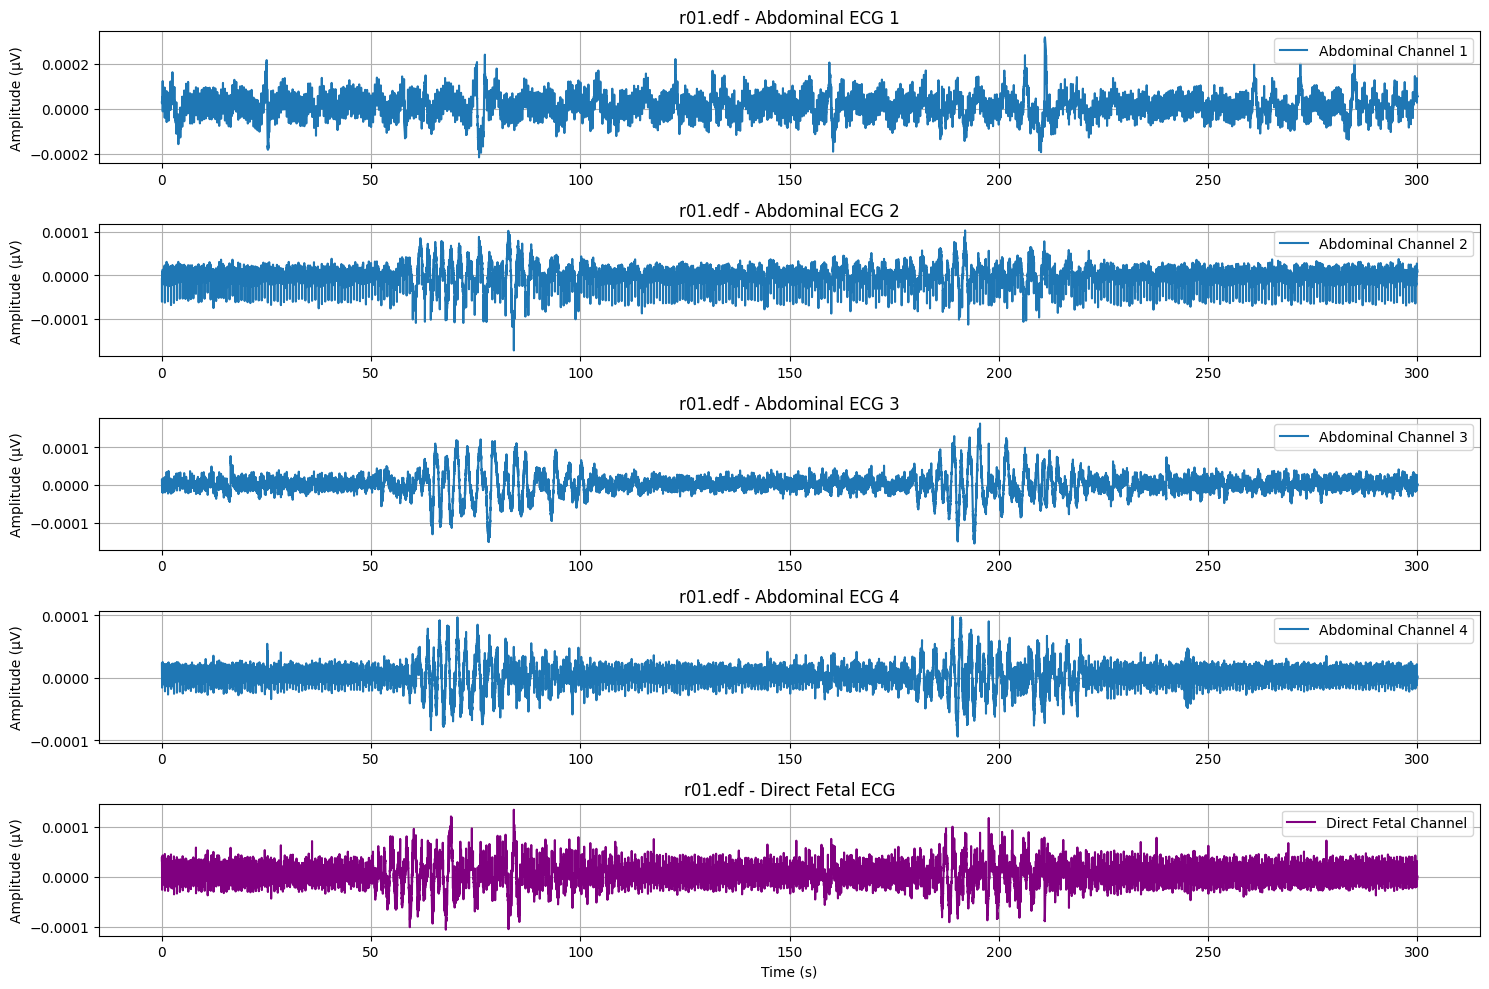


Loading r04.edf ...
Extracting EDF parameters from C:\Users\aparn\OneDrive\PROJECT_S3\IBS\abdominal-and-direct-fetal-ecg-database-1.0.0\r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Channels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling rate: 1000.0 Hz


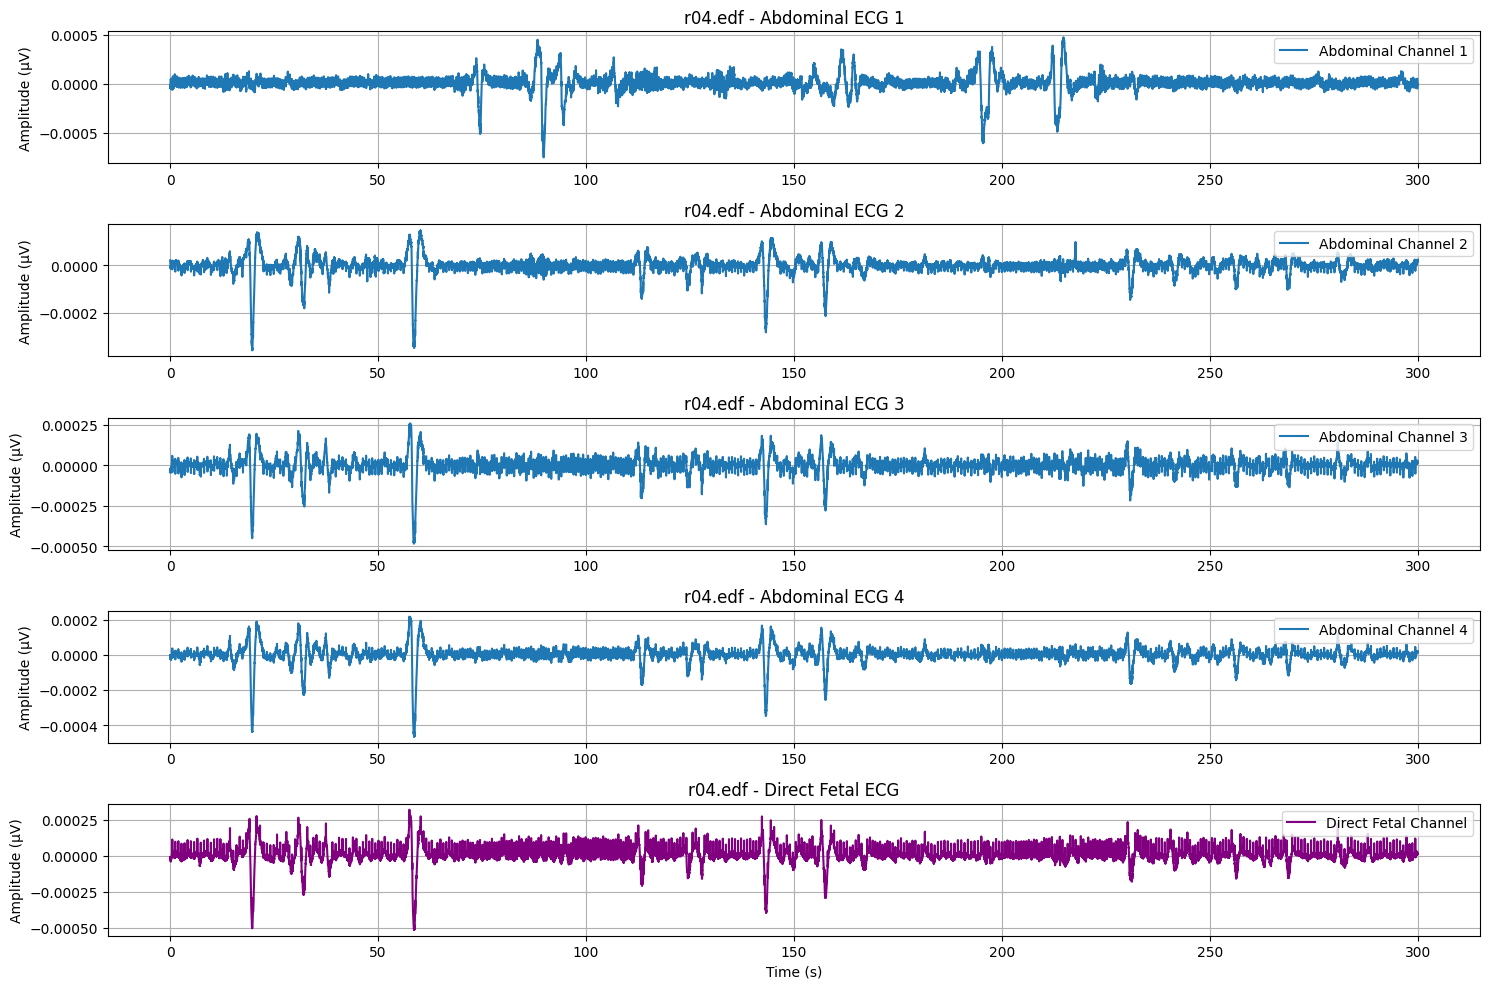


Loading r07.edf ...
Extracting EDF parameters from C:\Users\aparn\OneDrive\PROJECT_S3\IBS\abdominal-and-direct-fetal-ecg-database-1.0.0\r07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Channels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling rate: 1000.0 Hz


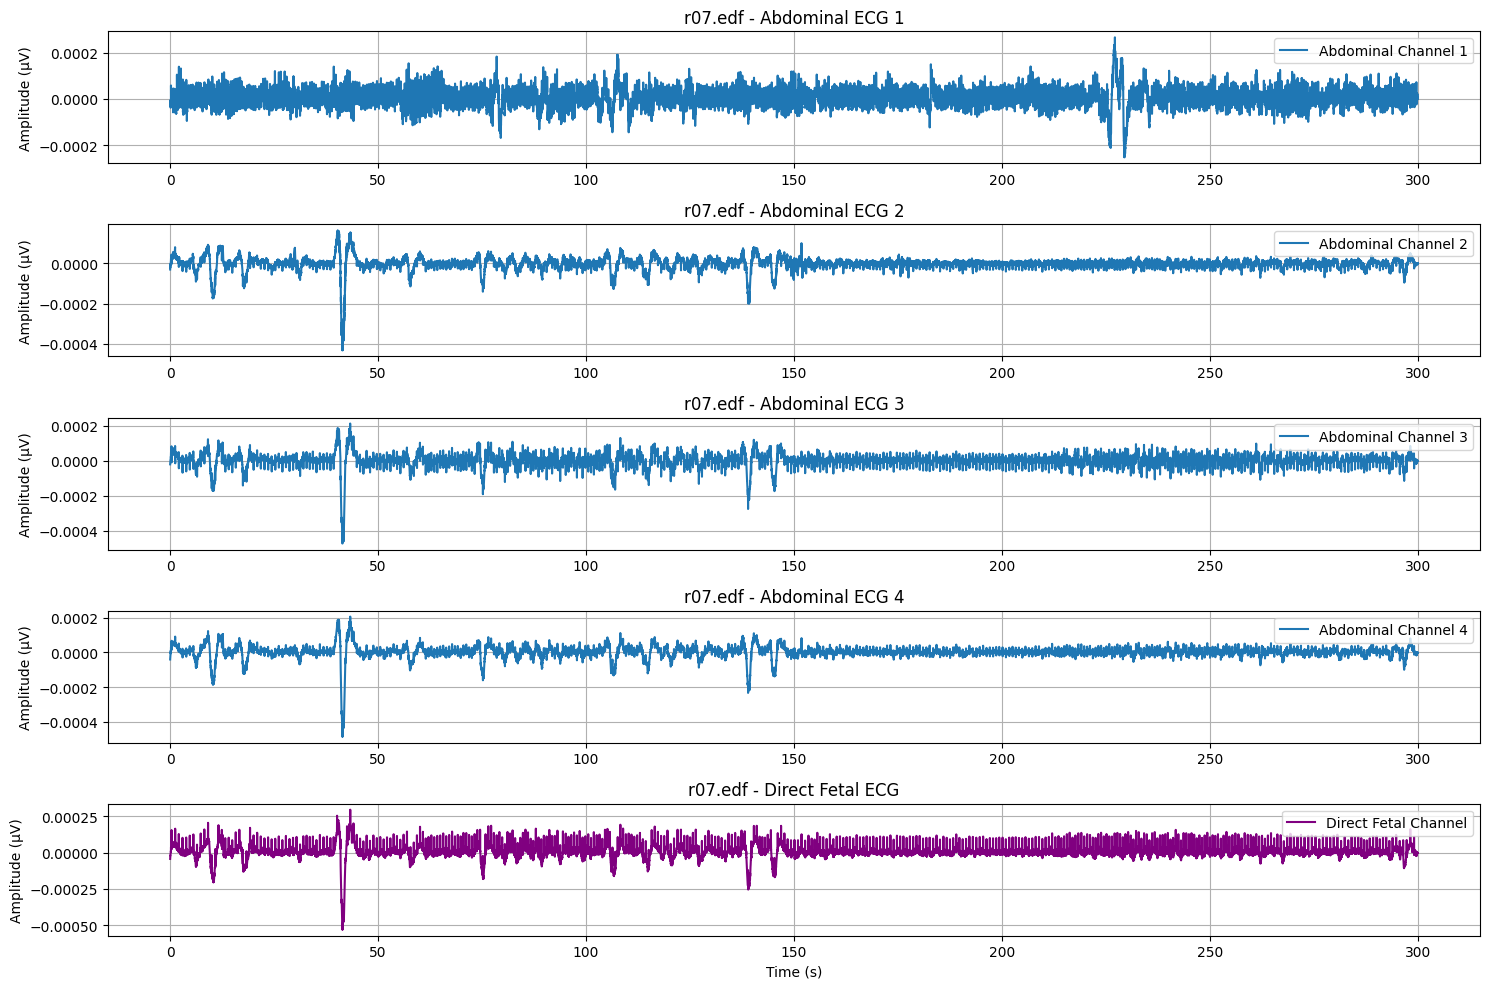


Loading r08.edf ...
Extracting EDF parameters from C:\Users\aparn\OneDrive\PROJECT_S3\IBS\abdominal-and-direct-fetal-ecg-database-1.0.0\r08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Channels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling rate: 1000.0 Hz


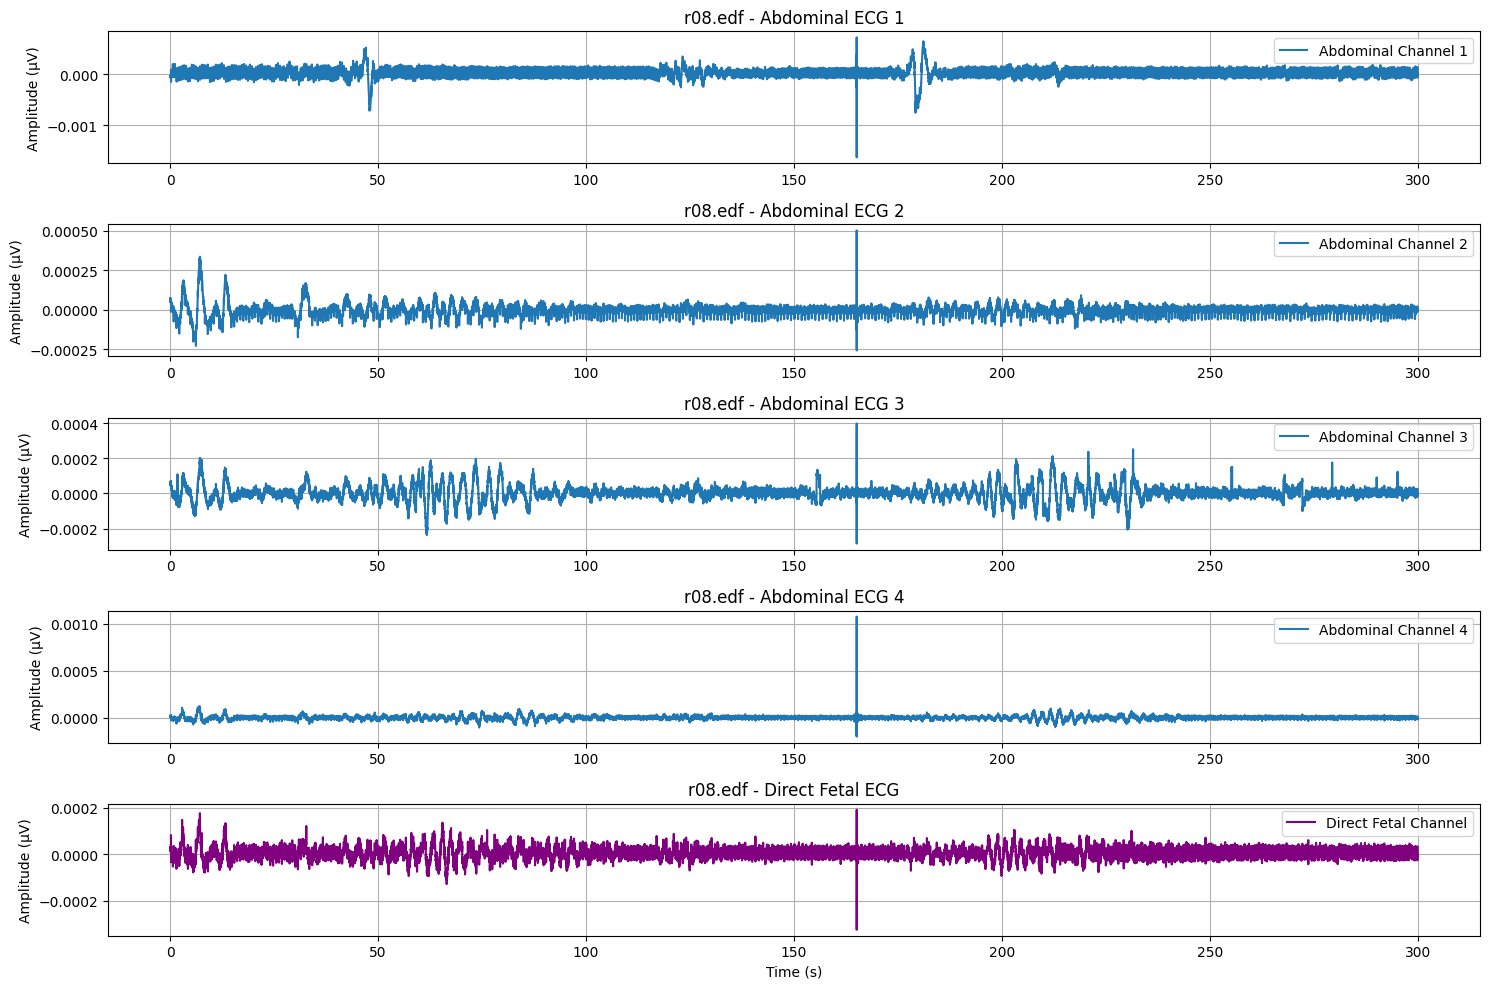


Loading r10.edf ...
Extracting EDF parameters from C:\Users\aparn\OneDrive\PROJECT_S3\IBS\abdominal-and-direct-fetal-ecg-database-1.0.0\r10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Channels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling rate: 1000.0 Hz


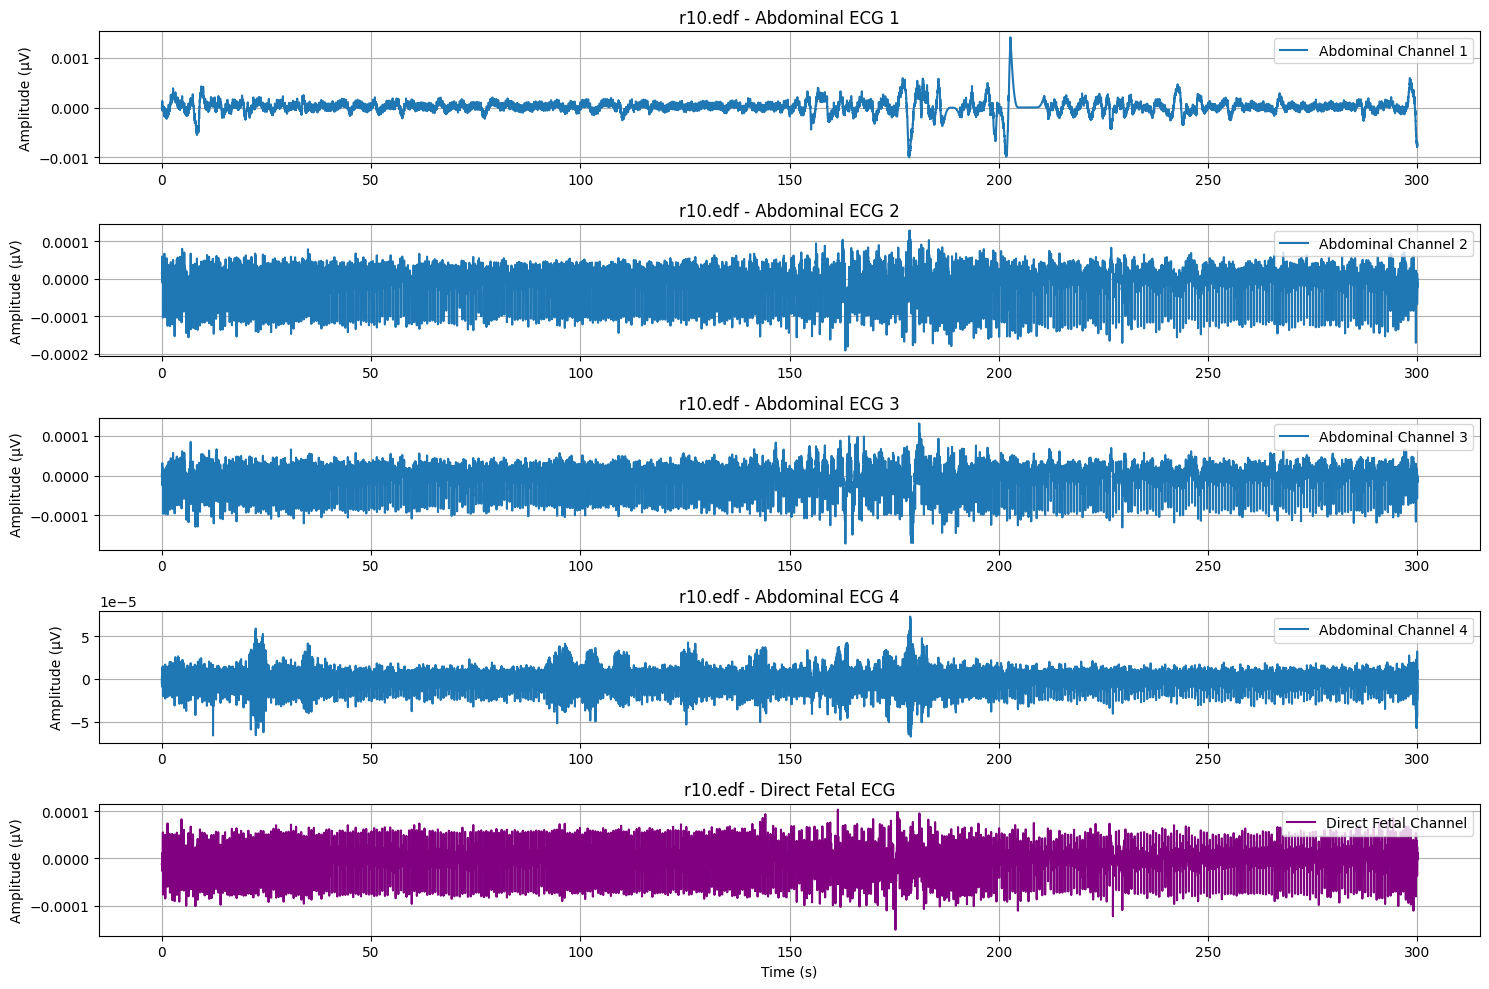

In [4]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder containing EDF files
base_path = r"C:\Users\aparn\OneDrive\PROJECT_S3\IBS\abdominal-and-direct-fetal-ecg-database-1.0.0"  # <-- Change to your folder path

# List all EDF files in the folder
edf_files = [f for f in os.listdir(base_path) if f.endswith('.edf')]
print("Found EDF files:", edf_files)

# Loop through each EDF file
for edf_file in edf_files:
    full_path = os.path.join(base_path, edf_file)
    print(f"\nLoading {edf_file} ...")
    
    raw = mne.io.read_raw_edf(full_path, preload=True)
    print("Channels:", raw.ch_names)
    print("Sampling rate:", raw.info['sfreq'], "Hz")
    
    # Extract first 5 channels (assume 4 abdominal + 1 fetal)
    data, times = raw[:5, :]
    
    # Plot
    plt.figure(figsize=(15, 10))
    for i in range(4):
        plt.subplot(5, 1, i+1)
        plt.plot(times, data[i], label=f'Abdominal Channel {i+1}')
        plt.ylabel('Amplitude (µV)')
        plt.title(f'{edf_file} - Abdominal ECG {i+1}')
        plt.grid(True)
        plt.legend(loc="upper right")
    
    plt.subplot(5, 1, 5)
    plt.plot(times, data[4], label='Direct Fetal Channel', color='purple')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.title(f'{edf_file} - Direct Fetal ECG')
    plt.grid(True)
    plt.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()


No EDF files found. Using synthetic data for demonstration.

Generating synthetic data...
Synthetic data generated.
Best fetal ECG component index: 1
Max correlation: 10000.0000
Direct/Simulated Fetal ECG HR: 159.06 BPM
Extracted Fetal ECG HR: 159.06 BPM


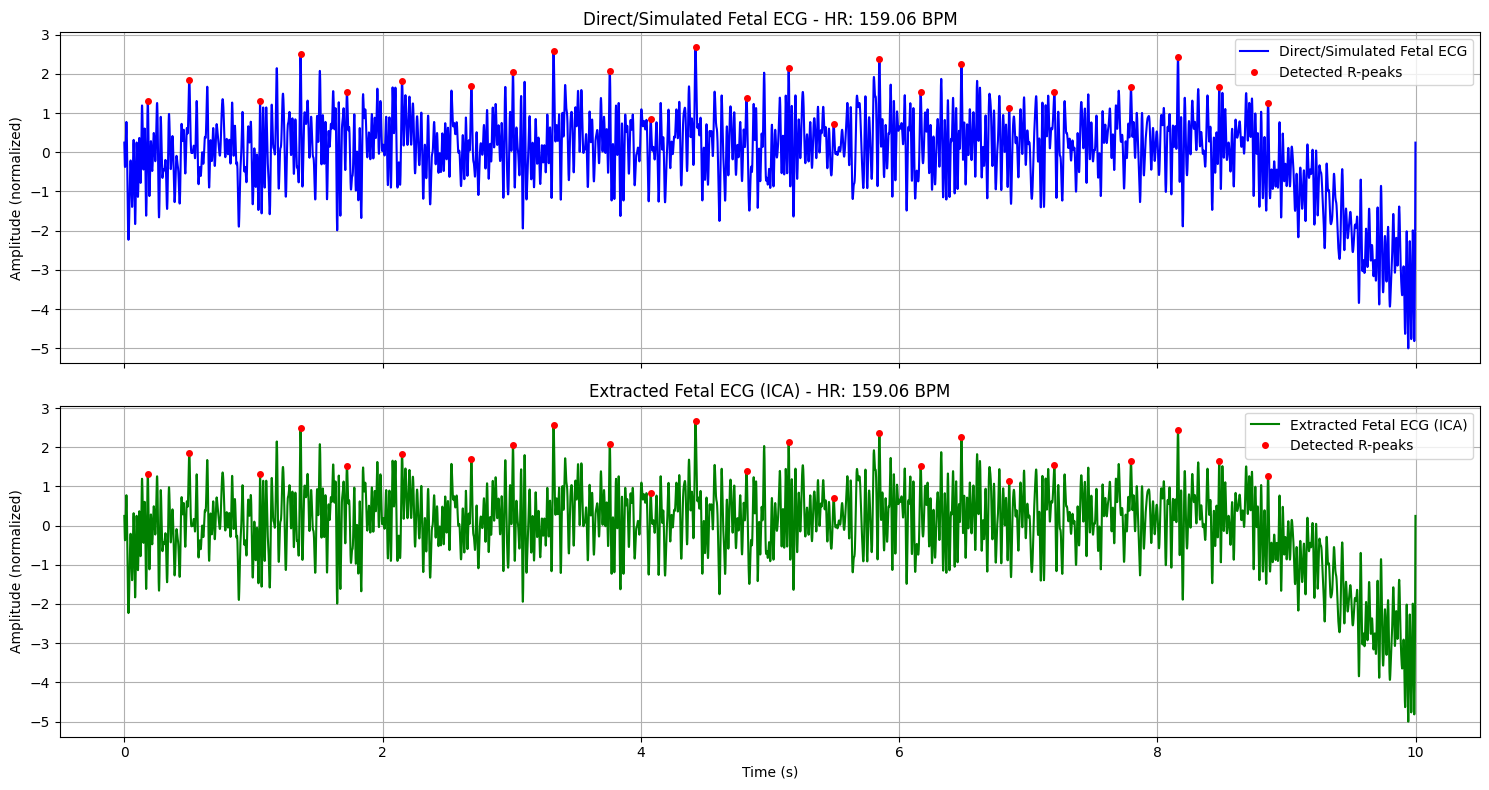


Processing complete.


In [5]:
# -------------------------------
# Fetal ECG Extraction using ICA
# -------------------------------
# Requirements:
# pip install mne scikit-learn numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.decomposition import FastICA
from scipy.signal import find_peaks
import os

# -------------------------------
# Config
# -------------------------------
# Folder containing EDF files (or leave empty for synthetic test)
edf_folder = r""  # e.g., r"C:\Users\Aparna\EDF_data"
low_cutoff = 0.5
high_cutoff = 45.0

# -------------------------------
# Helper Functions
# -------------------------------
def bandpass_filter(data, sfreq, low, high):
    return mne.filter.filter_data(data, sfreq, low, high, verbose=False)

def normalize_signal(sig):
    return (sig - np.mean(sig)) / np.std(sig)

def detect_r_peaks(signal, sfreq):
    normalized_signal = normalize_signal(signal)
    peaks, _ = find_peaks(normalized_signal, distance=int(0.3*sfreq), height=0.5)
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / sfreq
        heart_rate_bpm = 60 / np.mean(rr_intervals)
        return peaks, heart_rate_bpm
    else:
        return peaks, 0

# -------------------------------
# Step 0: Check EDF files
# -------------------------------
edf_files = []
if edf_folder and os.path.exists(edf_folder):
    edf_files = [f for f in os.listdir(edf_folder) if f.endswith('.edf')]

if not edf_files:
    print("No EDF files found. Using synthetic data for demonstration.")
    use_synthetic = True
else:
    print("Found EDF files:", edf_files)
    use_synthetic = False

# -------------------------------
# Step 1: Process Each File or Synthetic Data
# -------------------------------
for idx, edf_file in enumerate(edf_files if not use_synthetic else [None]):
    
    if use_synthetic:
        print("\nGenerating synthetic data...")
        sfreq = 1000  # Hz
        t = np.arange(0, 10, 1/sfreq)  # 10 seconds
        n_samples = t.size
        # Simulate 4 abdominal channels
        abdominal_data_T = np.array([
            0.5*np.sin(2*np.pi*1.2*t) + 0.05*np.random.randn(n_samples) for _ in range(4)
        ]).T
        # Simulate direct fetal ECG
        direct_fecg_data = 0.5*np.sin(2*np.pi*1.2*t + 0.1) + 0.05*np.random.randn(n_samples)
        print("Synthetic data generated.")
    else:
        full_path = os.path.join(edf_folder, edf_file)
        print(f"\nLoading EDF file: {edf_file}")
        try:
            raw = mne.io.read_raw_edf(full_path, preload=True)
            sfreq = raw.info['sfreq']
            # Assume standard channel names
            abdomen_channels = ['Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
            direct_channel = 'Direct_1'
            # Check channels
            if not all(ch in raw.ch_names for ch in abdomen_channels + [direct_channel]):
                raise ValueError("Required channels missing in EDF")
            abdominal_data = raw.get_data(picks=abdomen_channels)
            direct_fecg_data = raw.get_data(picks=direct_channel).squeeze()
            abdominal_data_T = abdominal_data.T
        except Exception as e:
            print(f"Skipping file {edf_file} due to error: {e}")
            continue

    # -------------------------------
    # Step 2: Filter and Normalize
    # -------------------------------
    filtered_abdominal = bandpass_filter(abdominal_data_T.T, sfreq, low_cutoff, high_cutoff)
    filtered_direct_fecg = bandpass_filter(direct_fecg_data, sfreq, low_cutoff, high_cutoff)
    filtered_abdominal_norm = (filtered_abdominal - filtered_abdominal.mean(axis=1)[:, None]) / filtered_abdominal.std(axis=1)[:, None]
    filtered_direct_fecg_norm = normalize_signal(filtered_direct_fecg)
    filtered_abdominal_norm_T = filtered_abdominal_norm.T

    # -------------------------------
    # Step 3: ICA
    # -------------------------------
    ica = FastICA(n_components=4, random_state=0, max_iter=1000)
    independent_components = ica.fit_transform(filtered_abdominal_norm_T)

    # -------------------------------
    # Step 4: Identify Best Fetal Component
    # -------------------------------
    correlations = []
    for i in range(independent_components.shape[1]):
        corr = np.correlate(independent_components[:, i], filtered_direct_fecg_norm if not use_synthetic else independent_components[:, i], mode='full')
        correlations.append(np.max(np.abs(corr)))
    best_comp_idx = np.argmax(correlations)
    best_fecg_component = independent_components[:, best_comp_idx]

    print(f"Best fetal ECG component index: {best_comp_idx}")
    print(f"Max correlation: {correlations[best_comp_idx]:.4f}")

    # -------------------------------
    # Step 5: Validation
    # -------------------------------
    direct_peaks, direct_hr = detect_r_peaks(filtered_direct_fecg if not use_synthetic else best_fecg_component, sfreq)
    extracted_peaks, extracted_hr = detect_r_peaks(best_fecg_component, sfreq)

    print(f"Direct/Simulated Fetal ECG HR: {direct_hr:.2f} BPM")
    print(f"Extracted Fetal ECG HR: {extracted_hr:.2f} BPM")

    # -------------------------------
    # Step 6: Plot Comparison
    # -------------------------------
    time_axis = np.arange(filtered_direct_fecg.size if not use_synthetic else best_fecg_component.size) / sfreq
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    # Direct or Simulated
    ax1.plot(time_axis, filtered_direct_fecg_norm if not use_synthetic else best_fecg_component, label='Direct/Simulated Fetal ECG', color='blue')
    ax1.plot(time_axis[direct_peaks], (filtered_direct_fecg_norm if not use_synthetic else best_fecg_component)[direct_peaks], 'ro', markersize=4, label='Detected R-peaks')
    ax1.set_title(f'Direct/Simulated Fetal ECG - HR: {direct_hr:.2f} BPM')
    ax1.set_ylabel('Amplitude (normalized)')
    ax1.legend()
    ax1.grid(True)
    # Extracted
    ax2.plot(time_axis, best_fecg_component, label='Extracted Fetal ECG (ICA)', color='green')
    ax2.plot(time_axis[extracted_peaks], best_fecg_component[extracted_peaks], 'ro', markersize=4, label='Detected R-peaks')
    ax2.set_title(f'Extracted Fetal ECG (ICA) - HR: {extracted_hr:.2f} BPM')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude (normalized)')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

print("\nProcessing complete.")
